## Protótipo Dashboard 
Neste protótipo, iremos mostrar quais dados e visualizações estarão presentes no dashboard WEB

<img src="https://i.gifer.com/7l6N.gif" width="400" height="400">

### Import das bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import date, time, datetime, timedelta
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

from models import Cliente, Local, Camera, Contagem

%matplotlib inline

CLIENTE_ID = 1

### Conexão com o banco

In [2]:
DB_CONN_STRING = 'postgres://postgres:@localhost:5433/peoplecounter'

engine = create_engine(DB_CONN_STRING, echo=False)

### Nosso cliente cadastrado

In [6]:
query = "SELECT nome AS nome_cliente FROM clientes"

clientes = pd.read_sql(query, engine)

In [7]:
clientes

,nome_cliente
0,DB SUPERMERCADOS


### Estabelecimentos do cliente cadastrados

In [8]:
query = "SELECT cl.nome AS cliente_nome, l.nome AS local_nome, l.cep, l.endereco, l.cidade, l.estado \
        FROM locais l \
        RIGHT JOIN clientes cl ON l.cliente_id = cl.cliente_id \
        WHERE l.cliente_id = {0} \
        ORDER BY l.local_id".format(CLIENTE_ID)

locais = pd.read_sql(query, engine)

In [9]:
locais 

,cliente_nome,local_nome,cep,endereco,cidade,estado
0,DB SUPERMERCADOS,DB CIDADE NOVA,69095-000,"AV. NOEL NUTELS, 1762 - CIDADE NOVA",MANAUS,AMAZONAS
1,DB SUPERMERCADOS,DB PARAIBA,69057-021,"AV. JORNALISTA HUMBERTO CALDERADO FILHO, 1.128...",MANAUS,AMAZONAS


### Cameras de cada estabelecimento do cliente cadastradas

In [10]:
query = "SELECT cl.nome AS cliente_nome, l.nome AS local_nome, cam.nome AS camera_nome \
        FROM cameras cam \
        RIGHT JOIN locais l ON cam.local_id = l.local_id \
        RIGHT JOIN clientes cl ON l.cliente_id = cl.cliente_id \
        WHERE cl.cliente_id = {0} \
        ORDER BY cam.camera_id".format(CLIENTE_ID)

cameras = pd.read_sql(query, engine)

In [11]:
cameras

,cliente_nome,local_nome,camera_nome
0,DB SUPERMERCADOS,DB CIDADE NOVA,CAMERA ENTRADA 1
1,DB SUPERMERCADOS,DB CIDADE NOVA,CAMERA ENTRADA 2
2,DB SUPERMERCADOS,DB PARAIBA,CAM_ENTRADA_1
3,DB SUPERMERCADOS,DB PARAIBA,CAM_ENTRADA_2


### Simulação de busca de local e camera por local pelo usuário na interface

Busca do local (estabelecimento) para o cliente 1 cadastrado 

In [18]:
busca_local = input("Digite o nome do estabelecimento: ")

Digite o nome do estabelecimento: ci


In [19]:
query = "SELECT cl.nome AS cliente_nome, l.nome AS local_nome, l.cep, l.endereco, l.cidade, l.estado \
        FROM locais l \
        RIGHT JOIN clientes cl ON l.cliente_id = cl.cliente_id \
        WHERE l.cliente_id = {0} AND l.nome LIKE '%%{1}%%'".format(CLIENTE_ID, busca_local.upper())

local_selecionado = pd.read_sql(query, engine)

#### Abstraímos que o usuário selecionou o local que foi resultado da busca

In [20]:
local_selecionado

,cliente_nome,local_nome,cep,endereco,cidade,estado
0,DB SUPERMERCADOS,DB CIDADE NOVA,69095-000,"AV. NOEL NUTELS, 1762 - CIDADE NOVA",MANAUS,AMAZONAS


Busca da câmera a partir do local selecionado

In [21]:
busca_camera = input("Digite o nome/numero da camera: ")

Digite o nome/numero da camera: 1


In [22]:
query = "SELECT cl.nome AS cliente_nome, l.nome AS local_nome, cam.nome AS camera_nome \
        FROM cameras cam \
        RIGHT JOIN locais l ON cam.local_id = l.local_id \
        RIGHT JOIN clientes cl ON l.cliente_id = cl.cliente_id \
        WHERE l.cliente_id = {0} AND l.cep = '{1}' AND cam.nome LIKE '%%{2}%%'".format(CLIENTE_ID, local_selecionado.cep[0], busca_camera.upper())
    
camera_selecionada = pd.read_sql(query, engine)

#### Abstraímos que o usuário selecionou a câmera que foi resultado da busca

In [23]:
camera_selecionada

,cliente_nome,local_nome,camera_nome
0,DB SUPERMERCADOS,DB CIDADE NOVA,CAMERA ENTRADA 1


### Contagem de pessoas por câmera
Considera-se que cada camera cadastrada representa uma entrada diferente para o establecimento.
Neste exemplo, veremos os dados de contagem da camera selecionada do local escolhido pelo nosso cliente cadastrado.

In [15]:
query = "SELECT cont.timestamp, cont.qtd_pessoas_in \
        FROM contagem cont \
        RIGHT JOIN cameras cam ON cont.camera_id = cam.camera_id\
        RIGHT JOIN locais l ON cam.local_id = l.local_id \
        RIGHT JOIN clientes cl ON l.cliente_id = cl.cliente_id \
        WHERE cl.cliente_id = {0} AND l.cep = '{1}' AND cam.nome = '{2}' \
        ORDER BY cont.contagem_id".format(CLIENTE_ID, local_selecionado.cep[0], camera_selecionada.camera_nome[0])

contagem = pd.read_sql(query, engine)

2018-10-24 16:06:29,539 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2018-10-24 16:06:29,540 INFO sqlalchemy.engine.base.Engine {'name': "SELECT cont.timestamp, cont.qtd_pessoas_in         FROM contagem cont         RIGHT JOIN cameras cam ON cont.camera_id = cam.camera_id        RIGHT J ... (79 characters truncated) ... liente_id = cl.cliente_id         WHERE cl.cliente_id = 1 AND l.cep = '69095-000' AND cam.nome = 'CAMERA ENTRADA 1'         ORDER BY cont.contagem_id"}
2018-10-24 16:06:29,542 INFO sqlalchemy.engine.base.Engine SELECT cont.timestamp, cont.qtd_pessoas_in         FROM contagem cont         RIGHT JOIN cameras cam ON cont.camera_id = cam.camera_id        RIGHT JOIN locais l ON cam.local_id = l.local_id         RIGHT JOIN clientes cl ON l.cliente_id = cl.cliente_id         WHERE cl.cliente_id = 1 AND l.cep = '69095-000' AND cam.nome = 'CAMERA ENTR

In [27]:
contagem.head()

,timestamp,qtd_pessoas_in
0,2018-10-24 15:49:24.031656,0
1,2018-10-24 15:49:27.011704,0
2,2018-10-24 15:49:30.017785,0
3,2018-10-24 15:49:33.024115,2
4,2018-10-24 15:49:36.034400,2


#### Coletando dados de contagem de hoje

In [29]:
hoje = datetime.today()
dias_passados = hoje - timedelta(days=1)
contagem = contagem.query("timestamp < '{0}' and timestamp > '{1}'".format(hoje, dias_passados))

In [30]:
contagem.head()

,timestamp,qtd_pessoas_in
0,2018-10-24 15:49:24.031656,0
1,2018-10-24 15:49:27.011704,0
2,2018-10-24 15:49:30.017785,0
3,2018-10-24 15:49:33.024115,2
4,2018-10-24 15:49:36.034400,2


#### Resumo Estatístico

In [19]:
contagem.describe()

,qtd_pessoas_in
count,35.000000
mean,0.857143
std,1.088519
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,4.000000


#### Gráfico quantidade de pessoas por horário

In [98]:
tempo_inicio = contagem.timestamp.min()   
tempo_fim = contagem.timestamp.max()
intervalo_tempo = pd.date_range(start=tempo_inicio, end=tempo_fim, freq='3S')
qtd_pessoas = contagem.qtd_pessoas_in.value_counts()

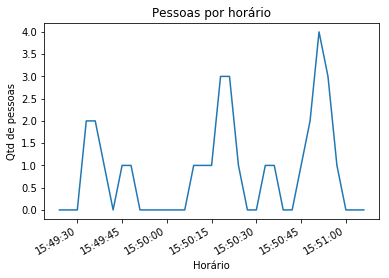

In [99]:
plt.plot(intervalo_tempo, contagem.qtd_pessoas_in)
plt.xlabel("Horário")
plt.ylabel("Qtd de pessoas")
plt.title("Pessoas por horário")
plt.gcf().autofmt_xdate()

Text(0.5, 1.0, 'Frequencia de pessoas hoje em todas as amostras de tempo')

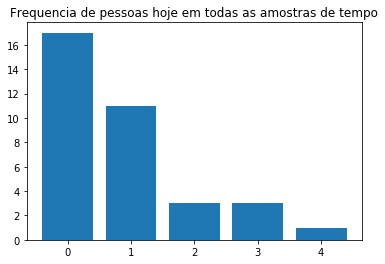

In [100]:
plt.bar(qtd_pessoas.index, qtd_pessoas)
plt.title("Frequencia de pessoas hoje em todas as amostras de tempo")

Text(0.5, 1.0, 'Frequencia (%) de pessoas hoje em todas as amostras de tempo')

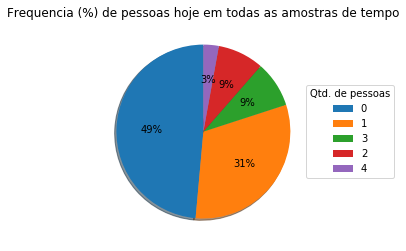

In [101]:
plt.pie(qtd_pessoas, autopct = "%.f%%", shadow=True, startangle=90)
plt.legend(qtd_pessoas.index, title="Qtd. de pessoas",loc="center right", bbox_to_anchor=(1, 0, 0.4, 1))
plt.title("Frequencia (%) de pessoas hoje em todas as amostras de tempo")